In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torch.nn.utils import clip_grad_norm_
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import numpy as np
import random
import copy
import os
import torch.optim as optim
from collections import Counter
from torchinfo import summary
from tqdm import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_transform = transforms.Compose([ 
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5)),  # 1 kanal normalize
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0)
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # 1 kanal normalize
])

# Veri setinde bulunan örnek yapılar şu şekilde ; 

```python 

dataset/
 ├── cat/
 │    ├── img1.jpg
 │    ├── img2.jpg
 │    └── ...
 └── dog/
      ├── img1.jpg
      ├── img2.jpg
      └── ...


## Biz bu yapıları train test olarak ayrı klasörlere ayıralım ve gelin daha rahat bir çözüm yoluna gidelim;


> ##### 0.8 - 0.2 

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Klasörlerin yolu
base_dir = r"C:\Users\hdgn5\OneDrive\Masaüstü\PyTorch - CNN - Uygulamalar\Datasets\Cat - Dog\dogs-vs-cats"
classes = ["cat", "dog"]

# Yeni klasör yapısı
output_dir = "dataset_split"
for split in ["train", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)


test_size = 0.2
random_state = 42

for cls in classes:
    files = os.listdir(os.path.join(base_dir, cls))
    train_files, test_files = train_test_split(files, test_size=test_size, random_state=random_state)

    for f in train_files:
        src = os.path.join(base_dir, cls, f)
        dst = os.path.join(output_dir, "train", cls, f)
        shutil.copy(src, dst)

    for f in test_files:
        src = os.path.join(base_dir, cls, f)
        dst = os.path.join(output_dir, "test", cls, f)
        shutil.copy(src, dst)

print("Ayrım tamam ")


Ayrım tamam 


In [6]:
train_dataset = datasets.ImageFolder(root=r"C:\Users\hdgn5\OneDrive\Masaüstü\PyTorch - CNN - Uygulamalar\Uygulamalar\Uygulama - 1\dataset_split\train" , transform= train_transform)
test_dataset = datasets.ImageFolder(root=r"C:\Users\hdgn5\OneDrive\Masaüstü\PyTorch - CNN - Uygulamalar\Uygulamalar\Uygulama - 1\dataset_split\test",transform=test_transform)

In [7]:
train_loader = DataLoader(  train_dataset , batch_size=32 , shuffle=True)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=32)

In [8]:
labels_test = [label for _ , label in test_dataset]
counts_txt = Counter(labels_test)

for idx , cls in enumerate(test_dataset.classes):
   print(f"{cls} : {counts_txt[idx]} örnek")

cat : 1000 örnek
dog : 1000 örnek


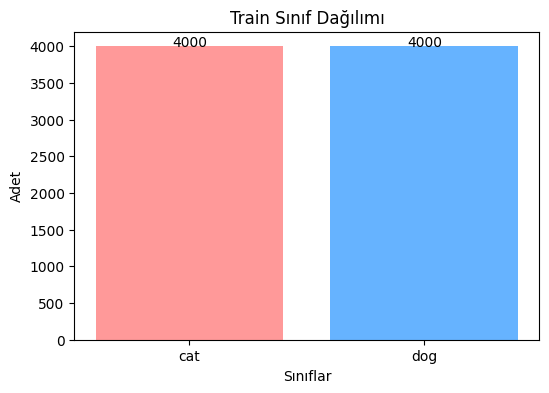

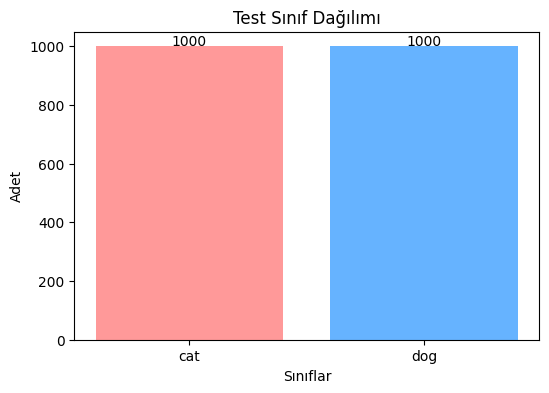

Train dataset boyutu: 8000
Test dataset boyutu: 2000


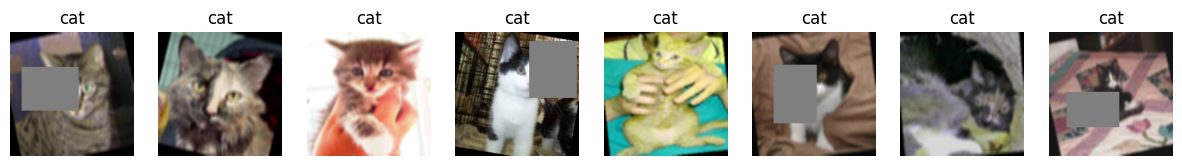

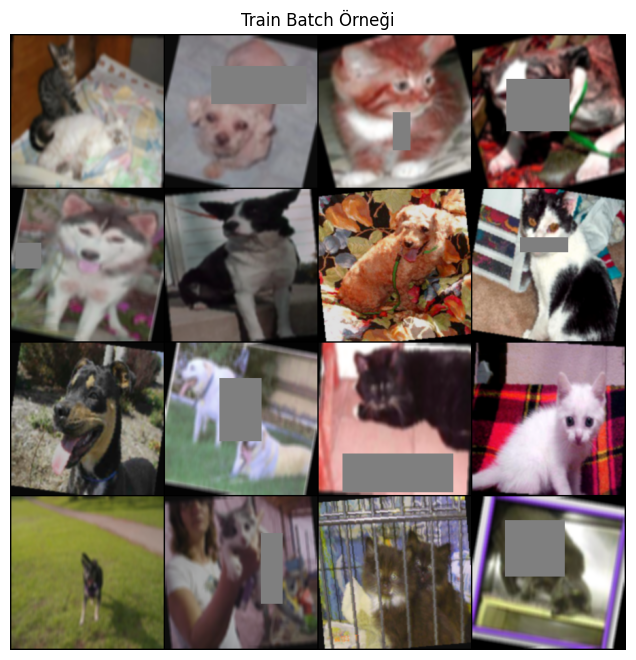

Batch boyutu: 32


In [9]:

def plot_class_distribution(dataset, title="Sınıf Dağılımı"):
    labels = [label for _, label in dataset]
    counts = Counter(labels)
    
    plt.figure(figsize=(6,4))
    plt.bar(dataset.classes, [counts[i] for i in range(len(dataset.classes))], color=["#ff9999","#66b3ff"])
    plt.title(title)
    plt.xlabel("Sınıflar")
    plt.ylabel("Adet")
    for idx, cls in enumerate(dataset.classes):
        plt.text(idx, counts[idx]+2, str(counts[idx]), ha="center")
    plt.show()

plot_class_distribution(train_dataset, title="Train Sınıf Dağılımı")
plot_class_distribution(test_dataset, title="Test Sınıf Dağılımı")


print(f"Train dataset boyutu: {len(train_dataset)}")
print(f"Test dataset boyutu: {len(test_dataset)}")


def show_examples(dataset, n=8):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        img, label = dataset[i]
        img = img.permute(1, 2, 0)  # C,H,W -> H,W,C
        axes[i].imshow((img * 0.5 + 0.5).numpy())  # Normalizasyonu geri al
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

show_examples(train_dataset, n=8)

images, labels = next(iter(train_loader))
grid_img = make_grid(images[:16], nrow=4, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1,2,0))
plt.axis('off')
plt.title("Train Batch Örneği")
plt.show()

print(f"Batch boyutu: {images.size(0)}")


In [10]:
def get_mean_std(dataset, n=1000):
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    mean = 0.
    std = 0.
    total = 0
    for i, (images, _) in enumerate(loader):
        if i*32 > n: break
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += batch_samples
    mean /= total
    std /= total
    return mean, std

mean, std = get_mean_std(train_dataset)
print(f"Train set ortalama piksel değeri: {mean}")
print(f"Train set piksel std değeri: {std}")

Train set ortalama piksel değeri: tensor([-0.0907, -0.1458, -0.2119])
Train set piksel std değeri: tensor([0.4434, 0.4323, 0.4248])


In [11]:
class SeBlock(nn.Module):
    def __init__(self, channels , reduction = 8 ):
        super().__init__()
        self.fc1 = nn.Linear(channels,channels// reduction)
        self.fc2 = nn.Linear(channels // reduction,channels)

    def forward(self,x):
        b,c,_,_ = x.size()
        y = torch.mean(x,dim=(2,3))
        y = F.silu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b,c,1,1)
        return x * y

In [12]:
class MiniBottleNeckSe(nn.Module):
    def __init__(self, in_channels, out_channels , stride=1,use_projection = False , p_drop =0.05):
        super().__init__()
        mid_channels = max(1,out_channels // 4)
        self.p_drop = p_drop

        self.layers = nn.ModuleList()
        chanells = [in_channels , mid_channels , mid_channels ,out_channels]
        kernel_sizes = [1,3,1]
        strides = [1,stride,1]

        for i in range(3):
            self.layers.append(nn.BatchNorm2d(chanells[i]))
            self.layers.append(nn.SiLU())
            self.layers.append(nn.Conv2d(chanells[i] , chanells[i+1] , kernel_size=kernel_sizes[i] , stride=strides[i] , padding= 1 if kernel_sizes[i] == 3 else 0))

        if use_projection or in_channels != out_channels or stride!=1:
            self.shortcut = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
        else :
            self.shortcut = nn.Identity()
        
        self.se = SeBlock(out_channels,reduction=8)
    
    def forward(self,x):
        identity = self.shortcut(x)
        out = x

        for i in range(0,len(self.layers),3):
            out = self.layers[i](out)
            out = self.layers[i+1](out)
            out = self.layers[i+2](out)

        if self.training and torch.rand(1).item() < self.p_drop:
            out = identity
        
        out = self.se(out)
        out += identity
        return out

In [13]:
class MiniCNNSe(nn.Module):
    def __init__(self, input_channels = 3, num_classes = 1 , conv_channels =[64,128,256] , r_b = 1):
        super().__init__()

        self.conv_layers = nn.ModuleList()
        self.res_block = nn.ModuleList()
        in_ch = input_channels

        for out_ch in conv_channels:
            self.conv_layers.append(nn.Conv2d(in_ch,out_ch ,kernel_size=3 , stride=1 , padding=1))
            self.conv_layers.append(nn.BatchNorm2d(out_ch))

            for _ in range(r_b):
                stride_val = 2 if in_ch != out_ch else 1 
                use_prof = True if in_ch !=out_ch else False
                self.res_block.append(MiniBottleNeckSe(out_ch ,out_ch , stride=stride_val , use_projection=use_prof))
            
            in_ch = out_ch

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(conv_channels[-1] ,  num_classes)
    
    def forward(self,x):
        res_idx = 0
        for i in range(0,len(self.conv_layers),2):
            x = F.silu(self.conv_layers[i+1](self.conv_layers[i](x)))
            x = F.dropout2d(x,p=0.1 , training=self.training)

            for _ in range(1):
                x = self.res_block[res_idx](x)
                res_idx += 1

        x = self.global_pool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x 

In [14]:
model = MiniCNNSe(input_channels=3, num_classes=1).to(device)

In [15]:
summary(model, input_size=(32, 3, 224, 224), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
MiniCNNSe                                [32, 1]                   --
├─ModuleList: 1-5                        --                        (recursive)
│    └─0.weight                                                    ├─1,728
│    └─0.bias                                                      ├─64
│    └─1.weight                                                    ├─64
│    └─1.bias                                                      ├─64
│    └─2.weight                                                    ├─73,728
│    └─2.bias                                                      ├─128
│    └─3.weight                                                    ├─128
│    └─3.bias                                                      ├─128
│    └─4.weight                                                    ├─294,912
│    └─4.bias                                                      ├─256
│    └─5.weight                         

Layer (type:depth-idx)                   Output Shape              Param #
MiniCNNSe                                [32, 1]                   --
├─ModuleList: 1-5                        --                        (recursive)
│    └─0.weight                                                    ├─1,728
│    └─0.bias                                                      ├─64
│    └─1.weight                                                    ├─64
│    └─1.bias                                                      ├─64
│    └─2.weight                                                    ├─73,728
│    └─2.bias                                                      ├─128
│    └─3.weight                                                    ├─128
│    └─3.bias                                                      ├─128
│    └─4.weight                                                    ├─294,912
│    └─4.bias                                                      ├─256
│    └─5.weight                         

In [16]:
loss_fonk = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001 , weight_decay=1e-4 , betas=(0.9 , 0.999) , eps=1e-7)
lr_scheduler = ReduceLROnPlateau(optimizer,mode="min",patience=5,factor=0.4)

In [17]:
# ===== DÜZELTİLMİŞ EarlyStopping SINIFI =====
class EarlyStopping:
    def __init__(self, delta=0.0, patience=7, verbose=False, restore_best_weights=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.early_stop = False
        self.best_loss = None
        self.best_model_wts = None
        # flag adı method ile çakışmasın diye farklı isim kullandım
        self.restore_best_flag = restore_best_weights

    def __call__(self, val_loss, model):
        # ilk çağrıda en iyi kaydı al
        if self.best_loss is None:
            self.best_loss = val_loss
            if self.restore_best_flag:
                self.best_model_wts = copy.deepcopy(model.state_dict())
            if self.verbose:
                print(f"Initial best loss set: {self.best_loss:.4f}")
            return

        # iyileşme var mı?
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_flag:
                self.best_model_wts = copy.deepcopy(model.state_dict())
            if self.verbose:
                print(f"Val loss improved to {val_loss:.4f}. Best weights updated.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in val loss. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered.")

    def restore_best_weights(self, model):
        if self.restore_best_flag and self.best_model_wts is not None:
            model.load_state_dict(self.best_model_wts)
            if self.verbose:
                print("Best weights restored to model.")


In [18]:
for images, labels in train_loader:
    print("Labels shape:", labels.shape)
    print("Labels unique:", labels.unique())
    break


Labels shape: torch.Size([32])
Labels unique: tensor([0, 1])


In [20]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # CUDA hatalarını doğru satırda gör

epochs_num = 1
max_norm = 2
early_stopping = EarlyStopping(patience=7, verbose=True, restore_best_weights=True)

for epoch in range(epochs_num):
    start_time = time.time()
    model.train()
    train_loss = 0.0
    correct_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs_num}", leave=False):
        images, labels = images.to(device), labels.to(device).float()  # float BCELoss için

        optimizer.zero_grad()
        outputs = model(images).squeeze(1)  # (batch,1) -> (batch,)
        loss = loss_fonk(outputs, labels)
        loss.backward()

        clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        train_loss += loss.item()
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).long()
        correct_train += (preds == labels.long()).sum().item()

    # 🔹 Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images).squeeze(1)
            loss = loss_fonk(outputs, labels)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            correct_val += (preds == labels.long()).sum().item()

    # 🔹 Ortalama değerler
    train_loss /= len(train_loader)
    train_acc = 100 * correct_train / len(train_dataset)
    val_loss /= len(test_loader)
    val_acc = 100 * correct_val / len(test_dataset)

    # 🔹 LR scheduler
    lr_scheduler.step(val_loss)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{epochs_num} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}% | "
          f"Time: {epoch_time:.1f}s | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # 🔹 EarlyStopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# 🔹 En iyi ağırlıkları geri yükle
early_stopping.restore_best_weights(model)


Epoch 1/1 | Train Loss: 0.6587, Train Acc: 60.29% | Val Loss: 0.6545, Val Acc: 61.30% | Time: 223.7s | LR: 0.001000
Initial best loss set: 0.6545
Best weights restored to model.


## Kodların yalnızca birbiriyle çalışma prensibi anlatılması için yapılmış bir örnektir.Epoch 1 verilmiştir.Lütfen diğer örneği de inceleyiniz.